<font size = 7>DELE ST1504 CA1 Part B: Recurrent Neural Network </font>
<hr>
<font size = 4>
Name: Lee Hong Yi<br>
Admin No: 2223010<br>
Class: DAAA/FT/2B/07<br>
</font>
<hr>

__Objective:__ <br>
To develop a model that predicts the next word in a sequence, using a provided dataset. The model should be able to generate creative and meaningful sequences of text based on input word sequences.

__Background Information:__<br>
Language is a dynamic and complex system, with words often following predictable patterns. By understanding these patterns, a model can be trained to predict the next word in a sequence. This capability is fundamental in various applications such as text completion, chatbots, and creative writing aids. The objective is to create a model that not only predicts the next word but also can generate diverse and contextually appropriate continuations.

__Additional Information:__ <br>
The model should be capable of generating different outputs for the same input sequence.<br>
The output should be evaluated for creativity and meaningfulness. <br>
A comparison between the outputs of a trained model and an untrained model will highlight the importance of training in language models.

__Output Variable:__ <br>
The word that follows a given sequence of words, with the ability to generate extended sequences (e.g., ten words) based on repeated predictions.
<hr>

<hr>
<font size = 5>Importing Libraries</font>
<hr>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import  Counter

import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

sns.set_style("darkgrid");
nltk.download('stopwords')

ModuleNotFoundError: No module named 'nltk'

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(tf.config.experimental.get_device_details(gpu))
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"There are {len(gpus)} GPU(s) present.")

<hr>
<font size = 5>Importing Data</font>
<hr>

In [ ]:
data = pd.read_csv("./train.csv")
print(data)

print(f'There are {len(data)} quotes in this dataset.')

                                                Quotes
0    Embrace the beauty of every sunrise; it's a fr...
1    Embrace challenges; they are the stepping ston...
2    Embrace the rhythm of life and let it dance th...
3    Embrace kindness, for it has the power to chan...
4    Embrace the journey, for it leads to the desti...
..                                                 ...
995  With an open heart, welcome the opportunities ...
996  This morning, let your laughter be the music t...
997  In the serenity of this morning, find the powe...
998  This morning, let your actions be a testament ...
999  With each sunrise, this morning offers the pro...

[1000 rows x 1 columns]
There are 1000 quotes in this dataset.


<hr>
<font size = 5>Exploratory Data Analysis (EDA)</font>
<hr>

In [ ]:
data.describe(include="all")

,Quotes
count,1000
unique,890
top,"Radiate acceptance, and find peace in embracin..."
freq,5


From the above, we can see that there are some quotes which are repeated within the dataset. We shall take note of this, and determine what to do with it later.

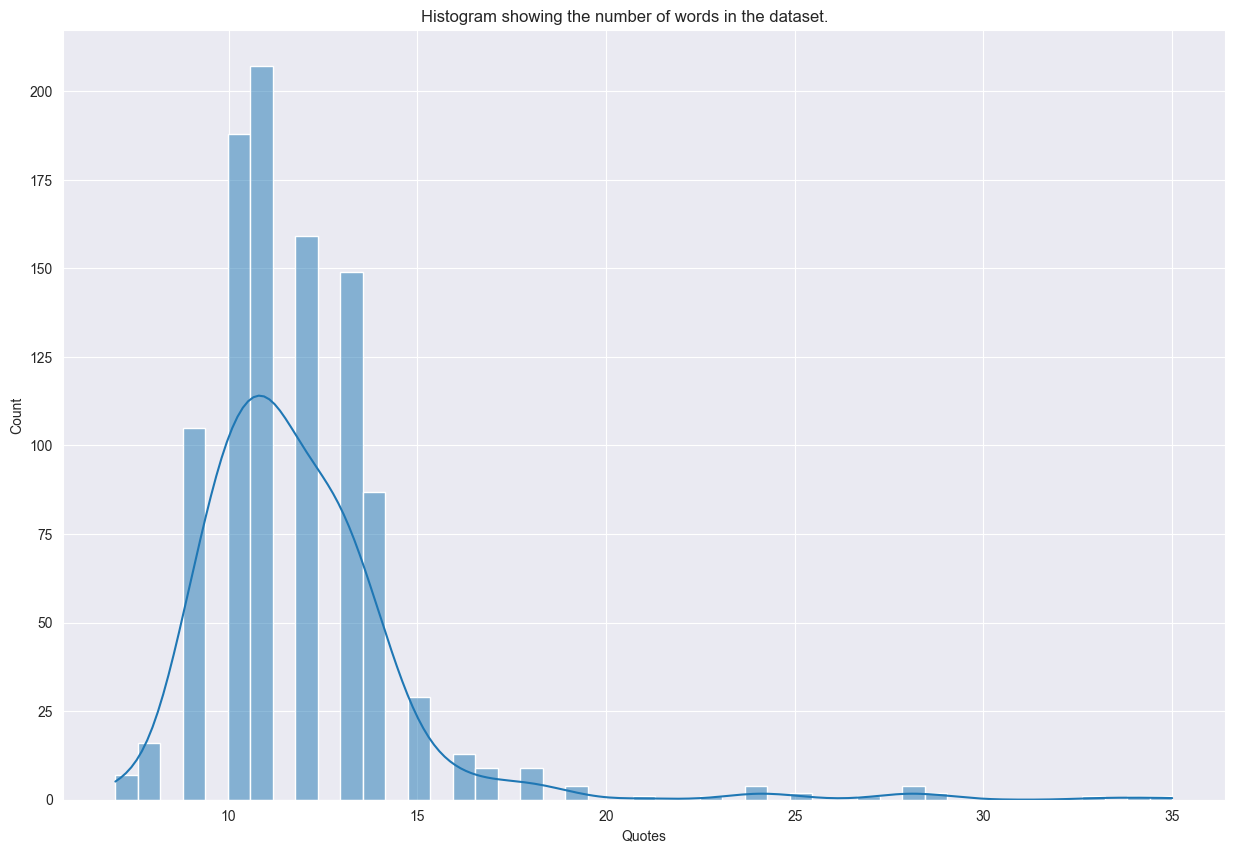

In [ ]:
fig = plt.figure(figsize = (15,10))
plt.suptitle("Histogram showing the number of words in the dataset.", y = 0.90)
sns.histplot(data["Quotes"].str.split().map(lambda x: len(x)), kde = True)
plt.show()

From the above graph, we can see that the model appears to have a higher frequency at around 10 to 15 quotes, with a significant drop in frequency above 20. It seems to also be right-skewed, owing to the long tail on the right.

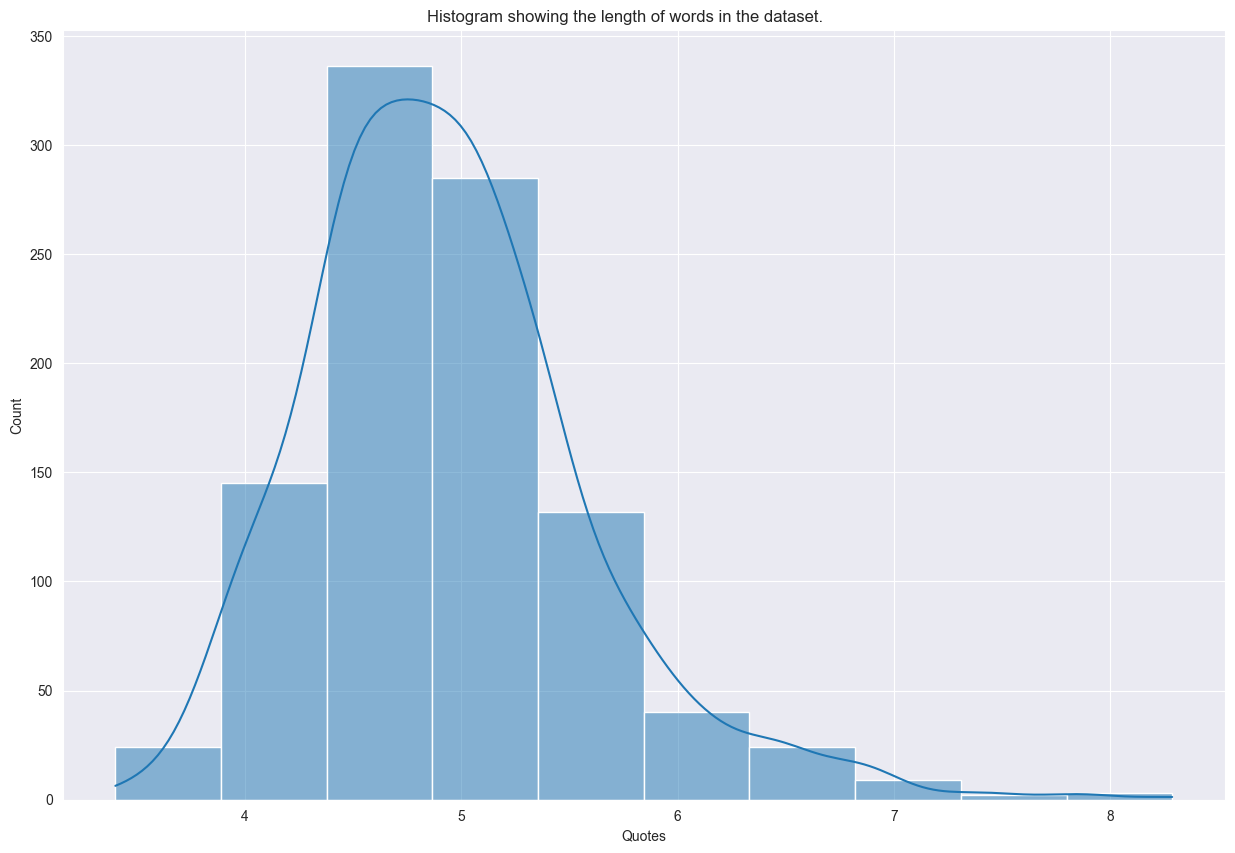

In [ ]:
fig = plt.figure(figsize = (15,10))
plt.suptitle("Histogram showing the length of words in the dataset.", y = 0.90)
sns.histplot(data["Quotes"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)), kde = True, bins = 10)
plt.show()

The average word length ranges between 3 to 9 with 5 being the most common length. Does it mean that people are using really short words in the dataset?

One reason why this may not be true is stopwords. Stopwords are the words that are most commonly used in any language such as “the”,” a”,” an” etc. 
As such words are usually short in length, these words may have caused the distribution to appear as such.

Analyzing the amount and the types of stopwords can give us some good insights into the data.

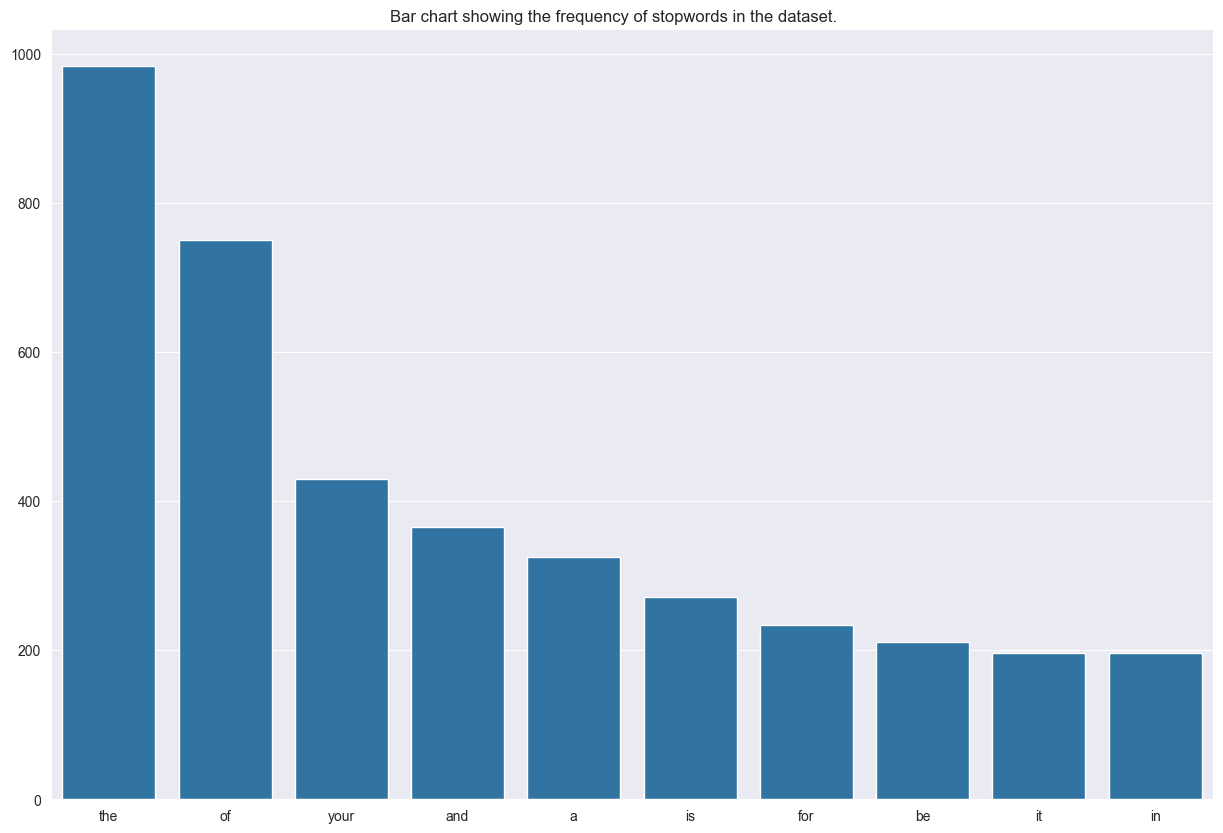

In [ ]:
stop=set(stopwords.words('english'))

new= data["Quotes"].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]
from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
fig = plt.figure(figsize = (15,10))
plt.suptitle("Bar chart showing the frequency of stopwords in the dataset.", y = 0.90)
sns.barplot(x = list(x), y = list(y))

plt.show()

From the above graph, we can see that the words "the", "of", "your", "and", and "a" appear quite frequently.

Now that we know which "stopwords" appear the most frequently, we can now check out which less frequently used words are used frequently in the dataset.

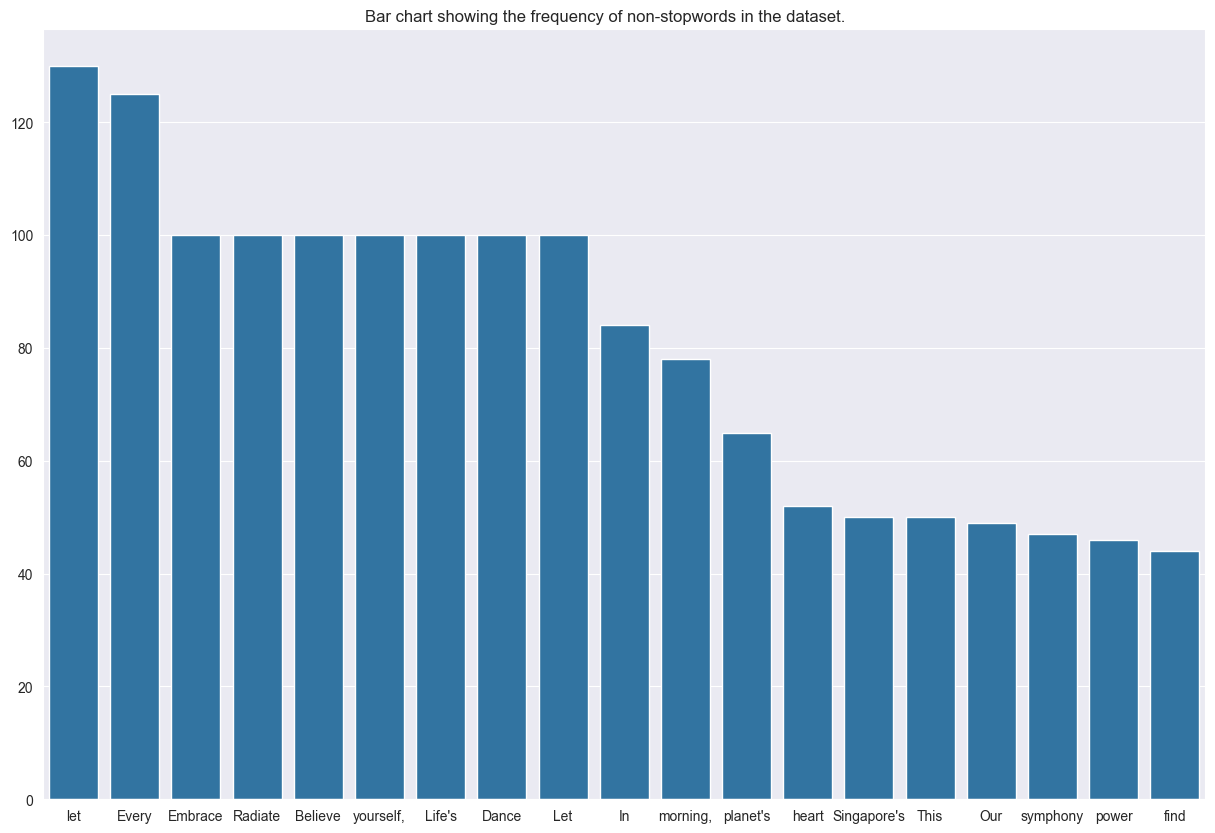

In [ ]:
stop = set(stopwords.words('english'))

new = data["Quotes"].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

fig = plt.figure(figsize=(15, 10))
plt.suptitle("Bar chart showing the frequency of non-stopwords in the dataset.", y = 0.90)
sns.barplot(x=x, y=y)
plt.show()

From the above, we can see that the words "let", "Every" are the most popular by far, with the words "Embrace", "Radiate", "Believe", "yourself,", "Life's", "Dance", and  "Let" all typing for 3rd place. The dataset seems to be very inspirational, and is something we can take note of when evaluating the results later.

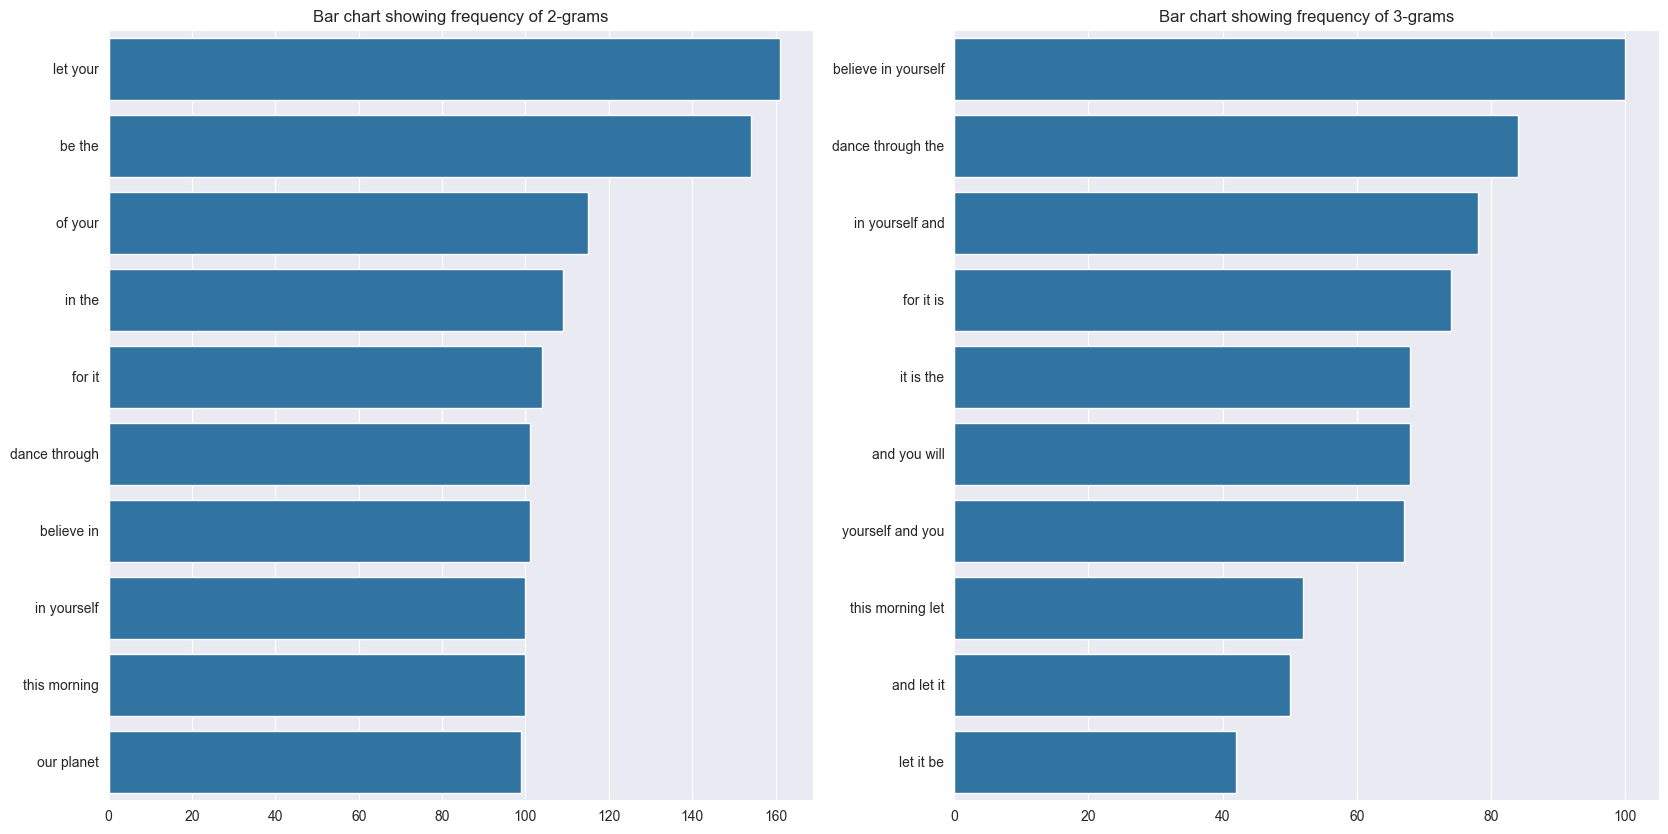

In [ ]:
def plot_top_ngrams_barchart(text, axs, n=2):
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams = _get_top_ngram(text, n)[:10]
    x, y = map(list, zip(*top_n_bigrams))
    ax = sns.barplot(x=y, y=x, ax = axs)
    return ax


fig, ax = plt.subplots(1,2, figsize = (20, 10))
plot_top_ngrams_barchart(data['Quotes'], ax[0], 2)
ax[0].set_title("Bar chart showing frequency of 2-grams")
plot_top_ngrams_barchart(data['Quotes'], ax[1], 3)
ax[1].set_title("Bar chart showing frequency of 3-grams")

plt.show()

The above graphs indicates that words conveying inspiration, such as "let" and "every," dominate the dataset, with a cluster of words like "embrace," "radiate," and "believe" sharing common frequency. This implies that the text has an uplifting and motivational tone. Similarly, the prominence of stopwords like "the," "of," and "your" suggests these brief, common words significantly shape the dataset's profile, potentially overshadowing less frequent but more meaningful words.


<hr>
<font size = 5>Data Preparation</font>
<hr>

<font size = 4> Data Cleaning</font>
<hr>

<font size = 4>Tokenization</font>
<hr>

<font size = 4>Vocabulary Building</font>
<hr>

<font size = 4>Numerical Encoding</font>
<hr>

<font size = 4>Creating Input and Output Sequences</font>
<hr>

<font size = 4>Data Splitting</font>
<hr>

<hr>
<font size = 5>Initial Modelling</font>
<hr>

Each of these architectures has its strengths and is chosen based on the specific requirements of the NLP task at hand. For instance, LSTMs and GRUs are often preferred for tasks requiring the understanding of long-term dependencies, while attention mechanisms and Transformer models are chosen for complex tasks requiring the understanding of context and relationships in the text.
<hr>

<font size = 4>Simple RNN</font>
<hr>

<font size = 4>LSTM (Long Short-Term Memory)</font>
<hr>

<font size = 4>GRU (Gated Recurrent Unit)</font>
<hr>

<font size = 4>Bi-Directional RNN</font>
<hr>

<font size = 4>Attention</font>
<hr>

<hr>
<font size = 5>Model Improvement</font>
<hr>

<font size = 4>Enhancing selected architecture</font>
<hr>

<font size = 4>Hypertuning</font>
<hr>

<hr>
<font size = 5>Final Evaluation</font>
<hr>

<hr>
<font size = 5>Conclusions</font>
<hr>